In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.float_format", "{:,.2f}".format)
pd.set_option("display.max_info_rows", 200)
           
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("cividis")

import pickle

import math

from tqdm import tqdm_notebook as tqdm

# Dataset

<font color='#20198A'>The dataset consists of 6362620 rows and 11 columns. </font>

<font color='black'>***step*** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

***type*** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

***amount*** - amount of the transaction in local currency (assume $).

***nameOrig*** - customer who started the transaction

***oldbalanceOrg*** - initial balance before the transaction

***newbalanceOrig*** - new balance after the transaction

***nameDest*** - customer who is the recipient of the transaction

***oldbalanceDest*** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

***newbalanceDest*** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

***isFraud*** - (TARGET) This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

***isFlaggedFraud*** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than $200,000 in a single transaction.</font>

In [71]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv") 

In [95]:
df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


In [75]:
df.rename(mapper={
    "nameOrig": "customer",
    "oldbalanceOrg": "customer_old_balance",
    "newbalanceOrig": "customer_new_balance",
    "nameDest": "recipient",
    "oldbalanceDest": "recipient_old_balance",
    "newbalanceDest": "recipient_new_balance",
    "isFraud": "is_fraud",
    "isFlaggedFraud": "is_flagged_fraud"
},
          axis=1,
          inplace=True)

df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.0","160,296.36",M1979787155,0.0,0.0,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.0","19,384.72",M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,"21,182.0",0.0,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.0","29,885.86",M1230701703,0.0,0.0,0,0


<font color='#20198A'>There are no null values:</font> 

In [76]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step                     6362620 non-null int64
type                     6362620 non-null object
amount                   6362620 non-null float64
customer                 6362620 non-null object
customer_old_balance     6362620 non-null float64
customer_new_balance     6362620 non-null float64
recipient                6362620 non-null object
recipient_old_balance    6362620 non-null float64
recipient_new_balance    6362620 non-null float64
is_fraud                 6362620 non-null int64
is_flagged_fraud         6362620 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [77]:
# pickle.dump(df, open("df.pkl", "wb"))

In [2]:
df = pickle.load(open("df.pkl", "rb"))

<font color='#20198A'>What are these \\$0 amount transactions? Also customer_old_balance and recipient_new_balance columns have \\$0 amounts.</font> 

In [96]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,"6,362,620.00",NaN,NaN,NaN,243.40,142.33,1.00,156.00,239.00,335.00,743.00
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,"6,362,620.00",NaN,NaN,NaN,"179,861.90","603,858.23",0.00,"13,389.57","74,871.94","208,721.48","92,445,516.64"
customer,6362620,6353307,C1784010646,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_old_balance,"6,362,620.00",NaN,NaN,NaN,"833,883.10","2,888,242.67",0.00,0.00,"14,208.00","107,315.18","59,585,040.37"
customer_new_balance,"6,362,620.00",NaN,NaN,NaN,"855,113.67","2,924,048.50",0.00,0.00,0.00,"144,258.41","49,585,040.37"
recipient,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recipient_old_balance,"6,362,620.00",NaN,NaN,NaN,"1,100,701.67","3,399,180.11",0.00,0.00,"132,705.66","943,036.71","356,015,889.35"
recipient_new_balance,"6,362,620.00",NaN,NaN,NaN,"1,224,996.40","3,674,128.94",0.00,0.00,"214,661.44","1,111,909.25","356,179,278.92"
is_fraud,"6,362,620.00",NaN,NaN,NaN,0.00,0.04,0.00,0.00,0.00,0.00,1.00


<font color='#20198A'>The numerical features have very low correlation to is_fraud.  We will need to do some feature engineering before we build the model.</font>

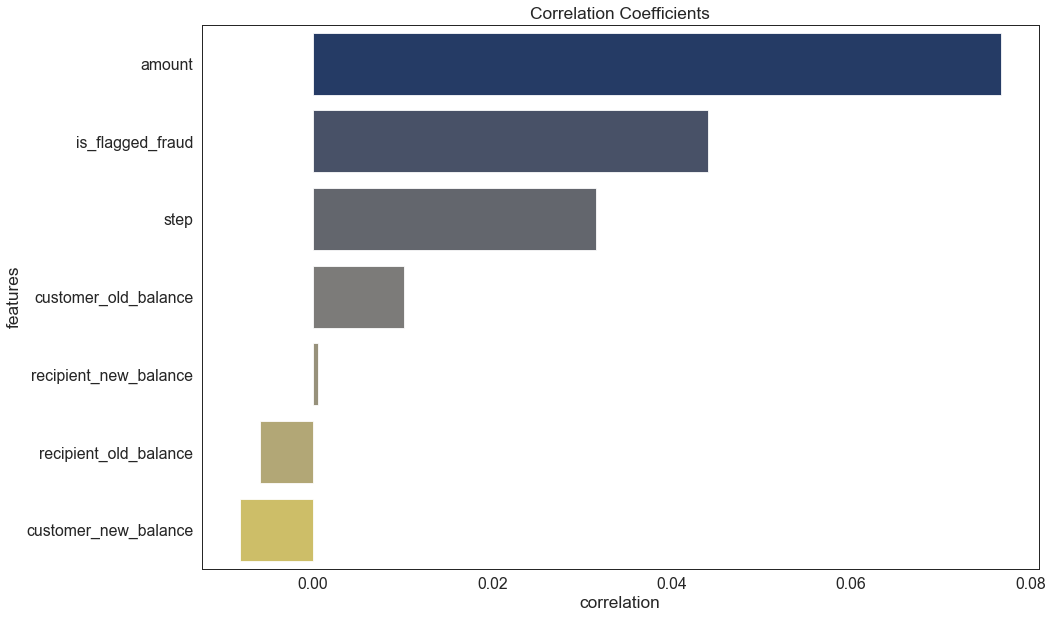

In [3]:
corr_table = df.corr()[["is_fraud"]].sort_values(
    "is_fraud", ascending=False).iloc[1:, :].reset_index()
plt.figure(figsize=(15, 10))
sns.barplot(x="is_fraud", y="index", data=corr_table, palette="cividis")
plt.xlabel("correlation")
plt.ylabel("features")
plt.title("Correlation Coefficients")
plt.show()
del corr_table

# Exploratory Data Analysis

## Target: is_fraud

1: fraud
0: not fraud

<font color='#20198A'> We will need to employ a resampling technique to fix the class imbalance.</font>

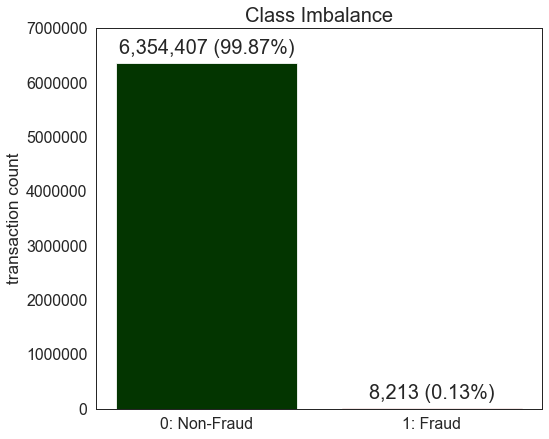

In [177]:
temp = df.groupby(["is_fraud"]).count().reset_index()
fig = plt.figure(figsize=(8, 7))
graph = plt.bar(temp.is_fraud, temp.step, color=["#033500", "#840000"])
plt.title("Class Imbalance", fontsize=20)
plt.ylabel("transaction count")
plt.yticks(range(0, 8000000, 1000000))
plt.xticks([0, 1], ["0: Non-Fraud", "1: Fraud"])
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bar.get_height() + 100000,
             "{:,} ({}%)".format(x, round(x / len(df) * 100, 2)),
             fontsize=20,
             ha="center",
             va="bottom")
plt.show()
del temp, fig, graph, bar, x

In [50]:
# cols = [
#     "amount", "customer_old_balance", "customer_new_balance",
#     "recipient_old_balance", "recipient_new_balance"
# ]

# r = math.ceil(len(cols)/2)

# for key, val in dict(
#         zip([1, 0],
#             ["Fradulent Transactions", "Non-Fradulent Transactions"])).items():
#     fig = plt.figure(figsize=(25, 7*r))
#     for i, col in enumerate(cols):
#         ax = fig.add_subplot(r, 2, i + 1)
#         sns.distplot(df.query("is_fraud == @key")[col])
#         plt.xlabel(None)
#         plt.title(col, fontsize=20, color="black")
#     plt.suptitle(val, fontsize=27, y=0.93, color="black")
#     plt.show()

In [49]:
# normalised = []
# for col in cols:
#     df[col+"_log"] = df[col].map(lambda x: np.log10(x+1))
#     normalised.append(col+"_log")

# r = math.ceil(len(cols)/2)

# for key, val in dict(
#         zip([1, 0],
#             ["Fradulent Transactions", "Non-Fradulent Transactions"])).items():
#     fig = plt.figure(figsize=(25, 7*r))
#     for i, col in enumerate(normalised):
#         ax = fig.add_subplot(r, 2, i + 1)
#         sns.distplot(df.query("is_fraud == @key")[col])
#         plt.xlabel(None)
#         plt.title(col, fontsize=20, color="black")
#     plt.suptitle(val, fontsize=27, y=0.93, color="black")
#     plt.show()

## step


Most of the transactions happened from 0 to 400. 

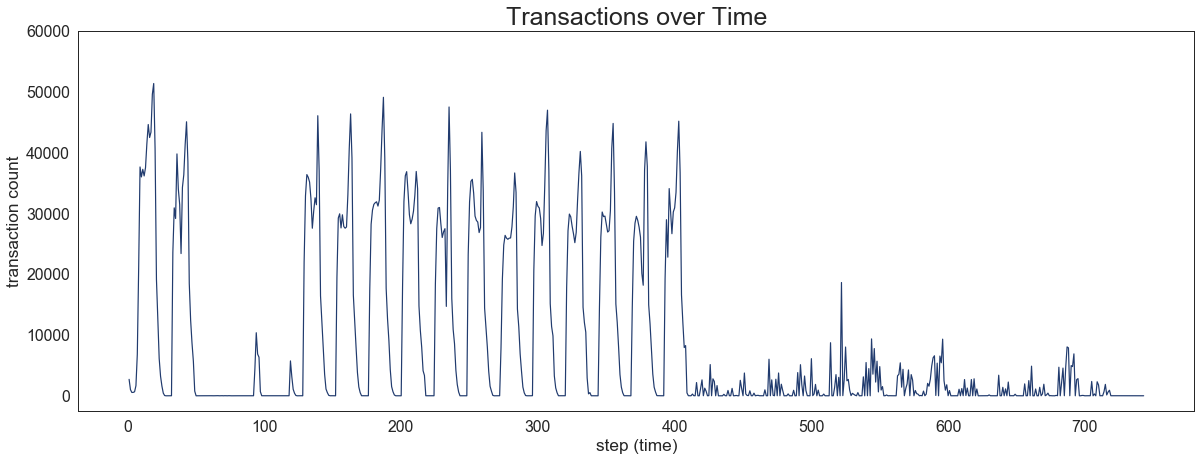

In [27]:
temp = df.groupby(["step"]).count().reset_index()
plt.figure(figsize=(20, 7))
sns.lineplot(x="step", y="amount", data=temp, color="C0")
plt.title("Transactions over Time", fontsize=25)
plt.xlabel("step (time)")
plt.ylabel("transaction count")
plt.yticks(range(0, 70000, 10000))
plt.show()
del temp

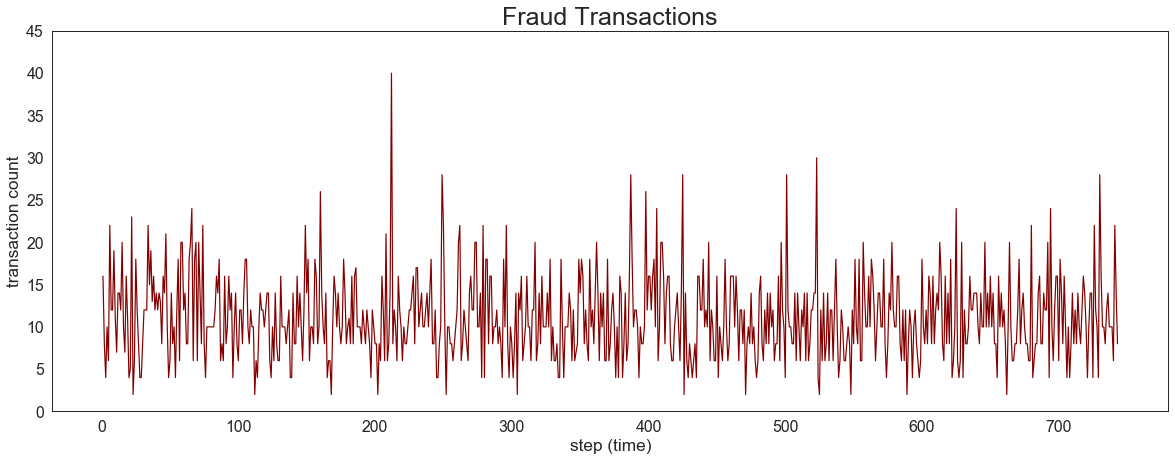

In [35]:
temp = df[df.is_fraud == 1].groupby(
    ["step"]).count().reset_index().sort_values(["type"], ascending=False)
plt.figure(figsize=(20, 7))
sns.lineplot(x="step", y="amount", data=temp, color="#840000")
plt.xlabel("step (time)")
plt.ylabel("transaction count")
plt.yticks(range(0, 50, 5))
plt.title("Fraud Transactions", fontsize=25)
plt.show()
del temp

## type


<font color='#20198A'>Most common types are CASH_OUT, PAYMENT and CASH_IN which comprises 91% of the dataset.  Fraudulent transactions are only found in CASH_OUT and TRANSFER transactions.</font>

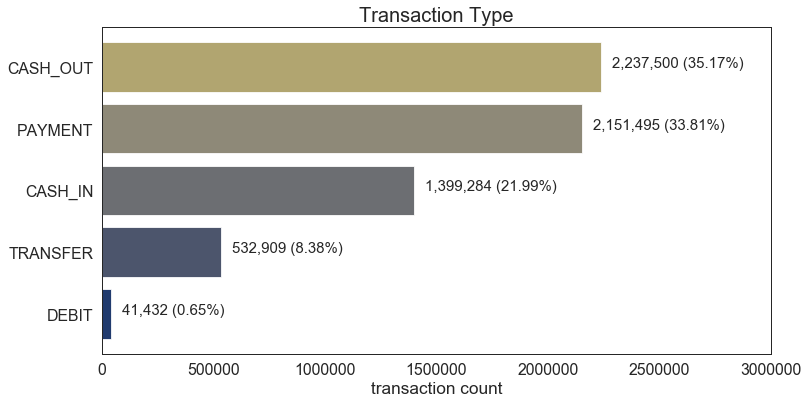

In [176]:
temp = df.groupby(["type"]).count().reset_index().sort_values("step")
fig = plt.figure(figsize=(12, 6))
graph = plt.barh(temp.type, temp.step, color=["C0", "C1", "C2", "C3", "C4"])
plt.title("Transaction Type", fontsize=20)
plt.xlabel("transaction count")
plt.xticks(range(0, 3500000, 500000))
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_width() + 50000,
             bar.get_y() + bar.get_height() / 2,
             "{:,} ({}%)".format(x, round(x / len(df) * 100, 2)),
             fontsize=15,
             ha="left")
plt.show()
del temp, fig, graph, bar, x

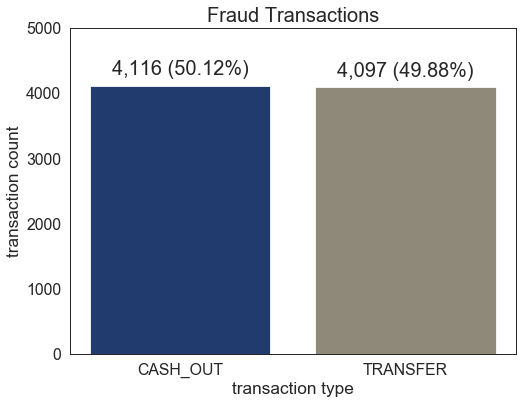

In [175]:
temp = df[df.is_fraud == 1].groupby(
    ["type"]).count().reset_index().sort_values("step", ascending=False)
fig = plt.figure(figsize=(8, 6))
graph = plt.bar(temp.type, temp.step, color=["C0", "C3"])
plt.title("Fraud Transactions", fontsize=20)
plt.xlabel("transaction type")
plt.ylabel("transaction count")
plt.yticks(range(0, 6000, 1000))
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 100,
             "{:,} ({}%)".format(x, round(x / len(df[df.is_fraud == 1]) * 100,
                                        2)),
             fontsize=20,
             ha="center",
             va="bottom")
plt.show()
del temp, fig, graph, bar, x

<font color='#20198A'>Are these fraudulent TRANSFER and CASH_OUT transactions related - money was transferred first then withdrawn?
    
Below, we sorted the table by amount and step then plotted the first 100 non-zero transactions. It seems that the fraud transfers and cash outs are related.</font>

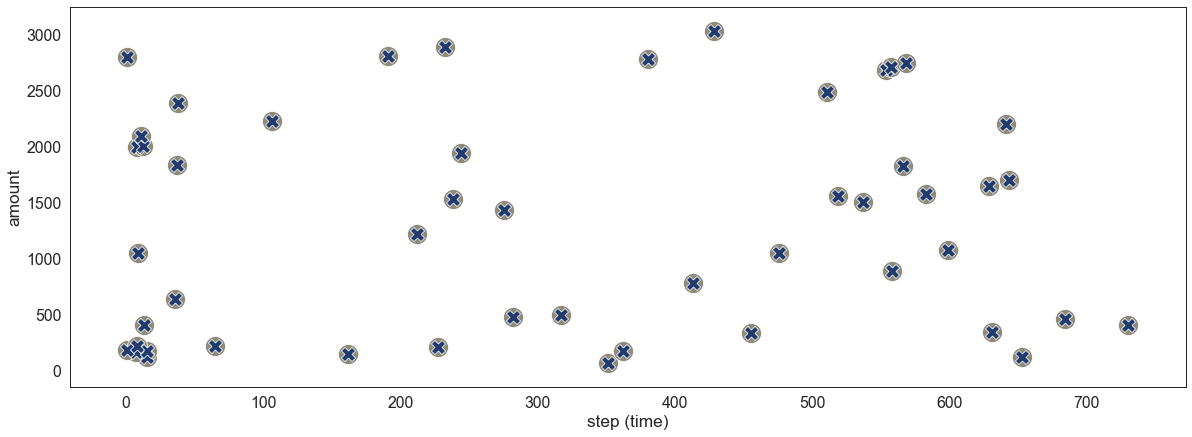

In [101]:
temp = df[(df.is_fraud == 1) & (df.amount !=0)].sort_values(["amount", "step"]).head(100)
plt.figure(figsize=(20, 7))
sns.scatterplot(x="step", y="amount", data=temp[temp.type=="TRANSFER"], color="C3", marker="o", s=400)
sns.scatterplot(x="step", y="amount", data=temp[temp.type=="CASH_OUT"], color="C0", marker="X", s=200)
plt.xlabel("step (time)")
plt.ylabel("amount")
plt.show()
del temp

<font color='#20198A'>However, looking at the below table, the IDs are not related i.e. the recipient ID of the TRANSFER is not the customer ID of CASH_OUT.</font>

In [102]:
df[(df.is_fraud == 1) & (df.amount !=0)].sort_values("amount").head(20)

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
4965641,351,TRANSFER,63.80,C1293504491,63.80,0.00,C1368130863,0.00,0.00,1,0
4965642,351,CASH_OUT,63.80,C1861878353,63.80,0.00,C958479953,0.00,63.80,1,0
277265,15,TRANSFER,119.00,C1995557473,119.00,0.00,C1480876722,0.00,0.00,1,0
277266,15,CASH_OUT,119.00,C1584512618,119.00,0.00,C2102058838,"4,844,060.13","4,844,179.13",1,0
6281816,653,CASH_OUT,119.65,C773613907,119.65,0.00,C1518370196,"1,183,575.58","1,183,695.22",1,0
6281815,653,TRANSFER,119.65,C1497766467,119.65,0.00,C543477940,0.00,0.00,1,0
1796322,162,TRANSFER,151.00,C1172437299,151.00,0.00,C315826176,0.00,0.00,1,0
1796323,162,CASH_OUT,151.00,C790340353,151.00,0.00,C517676411,"386,163.34","386,314.34",1,0
12180,7,CASH_OUT,164.00,C1173659886,164.00,0.00,C1769947269,"4,068.00",0.00,1,0
12179,7,TRANSFER,164.00,C1455969984,164.00,0.00,C2119910556,0.00,0.00,1,0


<font color='#20198A'>Let's check whether recipient IDs involved in fraudulent TRANSFER transactions made other CASH_OUT transactions.</font>

In [103]:
fraud_recipient_ID = df[(df.is_fraud == 1) & (df.type=="TRANSFER")].recipient.values
check_customer_ID = df[(df.customer.isin(fraud_recipient_ID)) & (df.type=="CASH_OUT")].customer.values
df[(df.customer.isin(check_customer_ID))| (df.recipient.isin(check_customer_ID))]
del fraud_recipient_ID, check_customer_ID

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
1030443,65,TRANSFER,"1,282,971.57",C1175896731,"1,282,971.57",0.00,C1714931087,0.00,0.00,1,0
1107905,130,CASH_OUT,"251,983.50",C737757614,"20,522.00",0.00,C1714931087,0.00,"251,983.50",0,0
1168398,132,CASH_OUT,"29,084.28",C1023330867,"51,999.00","22,914.72",C1422447255,0.00,"29,084.28",0,0
1168833,132,CASH_OUT,"202,763.68",C669553166,0.00,0.00,C1714931087,"251,983.50","454,747.18",0,0
1208192,133,CASH_IN,"59,605.39",C822001955,"5,663.00","65,268.39",C1714931087,"454,747.18","395,141.79",0,0
1257575,134,CASH_IN,"255,039.33",C1670222937,"64,265.00","319,304.33",C1714931087,"395,141.79","140,102.47",0,0
1446676,140,CASH_OUT,"103,156.75",C398595800,0.00,0.00,C1714931087,"140,102.47","243,259.21",0,0
1561591,155,CASH_IN,"205,460.04",C1268654690,"602,546.00","808,006.04",C1714931087,"243,259.21","37,799.17",0,0
2068070,181,CASH_IN,"5,965.93",C119615074,"120,674.00","126,639.93",C1714931087,"37,799.17","31,833.24",0,0
2186261,185,CASH_OUT,"214,555.85",C423543548,0.00,0.00,C1066927674,"4,575,179.83","4,789,735.69",0,0


In [87]:
df[(df.recipient == "C423543548") | (df.customer== "C423543548")]

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
2186261,185,CASH_OUT,"214,555.85",C423543548,0.0,0.0,C1066927674,"4,575,179.83","4,789,735.69",0,0
6039814,486,TRANSFER,"214,793.32",C2140495649,"214,793.32",0.0,C423543548,0.0,0.0,1,0


<font color='#20198A'>Should we just use CASH_OUT and TRANSFER type transactions to be build our model?

The numbers of data points that we need to process has gone done significantly but the dataset still has class imbalance.</font>

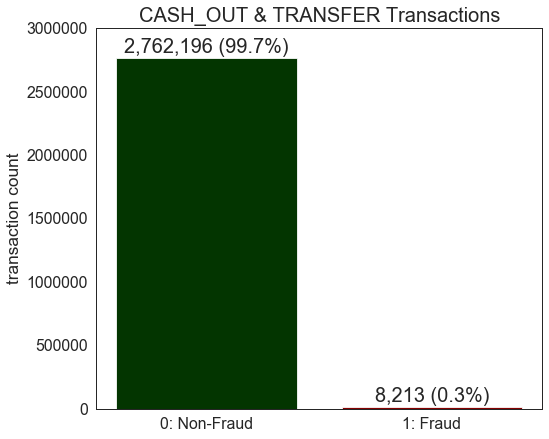

In [174]:
temp = df[df.type.isin(["CASH_OUT", "TRANSFER"])].groupby(["is_fraud"]).count().reset_index()
fig = plt.figure(figsize=(8, 7))
graph = plt.bar(temp.is_fraud, temp.step, color=["#033500", "#840000"])
plt.title("CASH_OUT & TRANSFER Transactions", fontsize=20)
plt.ylabel("transaction count")
plt.yticks(range(0, 3500000, 500000))
plt.xticks([0, 1], ["0: Non-Fraud", "1: Fraud"])
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bar.get_height() + 10000,
             "{:,} ({}%)".format(x, round(x / len(df[df.type.isin(["CASH_OUT", "TRANSFER"])]) * 100, 2)),
             fontsize=20,
             ha="center",
             va="bottom")
plt.show()
del temp, fig, graph, bar, x

In [145]:
# sns.catplot(x="is_fraud",
#             y="transaction count",
#             col="type",
#             data=df[(df.type == "CASH_OUT") | (df.type == "TRANSFER")].groupby(
#                 ["type", "is_fraud"]).count().reset_index().rename(
#                     mapper={"step": "transaction count"}, axis=1),
#             kind="bar",
#            palette="Set2")
# plt.show()

In [146]:
# for type_ in df.type.unique():
#     if list(df.type.unique()).index(type_) == 0:
#         print("====={}=====".format(type_))
#     else:
#         print("\n====={}=====".format(type_))
#     print(df.query("type == @type_").is_fraud.value_counts(normalize=True)*100)

## amount

<font color='#20198A'>The amount ranges from \\$0 to \\$92445516.64. The most common value is \\$10m which appeared 3207x. 287 transactions of which are fraudulent transactions.

This feature is skewed to the right.</font>

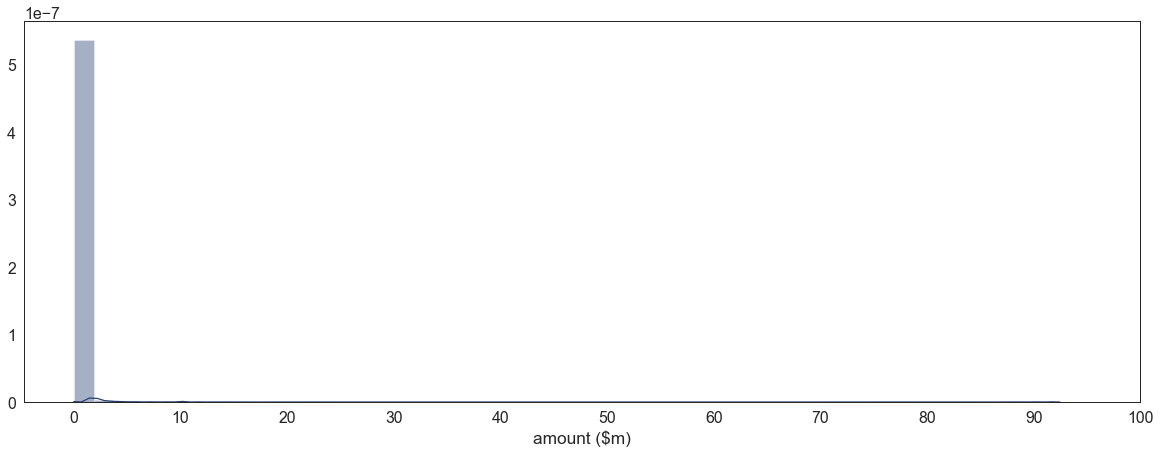

In [105]:
# fig = plt.figure(figsize=(25, 7))
# for i, col in enumerate(["amount", "amount_log"]):
#     ax = fig.add_subplot(1, 2, i + 1)
#     sns.distplot(df[col])
#     plt.xlabel(None)
#     plt.title(col, fontsize=20, color="black")
# plt.show()

fig = plt.figure(figsize=(20, 7))
sns.distplot(df.amount, color="C0")
plt.xticks(range(0, 110000000, 10000000), range(0, 110, 10))
plt.xlabel("amount ($m)")
plt.show()
del fig

In [106]:
pd.DataFrame(df.amount.value_counts().head(10)).reset_index().rename(mapper={
    "index":"amount",
    "amount":"count"
},
                                                                   axis=1)

,amount,count
0,"10,000,000.00",3207
1,"10,000.00",88
2,"5,000.00",79
3,"15,000.00",68
4,500.00,65
5,"100,000.00",42
6,"21,500.00",37
7,"120,000.00",29
8,"135,000.00",20
9,0.00,16


In [107]:
df[["amount", "is_fraud"]].pivot(columns="is_fraud").describe()

amount              
is_fraud             0             1
count    6,354,407.00  8,213.00     
mean     178,197.04    1,467,967.30 
std      596,236.98    2,404,252.95 
min      0.01          0.00         
25%      13,368.40     127,091.33   
50%      74,684.72     441,423.44   
75%      208,364.76    1,517,771.48 
max      92,445,516.64 10,000,000.00

In [108]:
pd.DataFrame(
    df[df.is_fraud == 1].amount.value_counts().head(10)).reset_index().rename(
        mapper={
            "index": "amount",
            "amount": "count"
        }, axis=1)

,amount,count
0,"10,000,000.00",287
1,0.00,16
2,"429,257.45",4
3,"1,165,187.89",4
4,"76,646.05",2
5,"25,529.76",2
6,"2,689,633.80",2
7,"296,699.39",2
8,"1,041,647.06",2
9,"447,474.67",2


<font color='#20198A'>These zero amount transactions are all fraudulent transactions. Customer old and new balances are both zero as well and there was no change to the recipient balances.  Is it possible that these transactions did not go through?</font>

In [109]:
zero = df[df.amount == 0]

zero["check_recipient_balance"] = zero["recipient_new_balance"] - zero[
    "recipient_old_balance"]
display(zero[[
    "amount", "type", "customer_old_balance", "customer_new_balance",
    "check_recipient_balance", "is_fraud", "is_flagged_fraud"
]])
del zero

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,amount,type,customer_old_balance,customer_new_balance,check_recipient_balance,is_fraud,is_flagged_fraud
2736447,0.00,CASH_OUT,0.00,0.00,0.00,1,0
3247298,0.00,CASH_OUT,0.00,0.00,0.00,1,0
3760289,0.00,CASH_OUT,0.00,0.00,0.00,1,0
5563714,0.00,CASH_OUT,0.00,0.00,0.00,1,0
5996408,0.00,CASH_OUT,0.00,0.00,0.00,1,0
5996410,0.00,CASH_OUT,0.00,0.00,0.00,1,0
6168500,0.00,CASH_OUT,0.00,0.00,0.00,1,0
6205440,0.00,CASH_OUT,0.00,0.00,0.00,1,0
6266414,0.00,CASH_OUT,0.00,0.00,0.00,1,0
6281483,0.00,CASH_OUT,0.00,0.00,0.00,1,0


In [179]:
# to_graph = df[df.customer_old_balance==0]

# fig = plt.figure(figsize=(20, 10))
# plt.scatter(to_graph.amount, to_graph.customer_old_balance, c=to_graph.is_fraud)
# plt.yticks(range(0, 100000000, 10000000), range(0, 100000, 10000))
# plt.yticks(range(0, 11000000, 1000000), range(0, 11000, 1000))
# plt.show

## customer, recipient

In [74]:
print("There are {} unique customer IDs.".format(df.customer.nunique()))

print("There are {} unique recipient IDs.".format(df.recipient.nunique()))

print("There are {} unique IDs in this dataset.".format(
    len(set(list(df.customer.unique()) + list(df.recipient.unique())))))

There are 6353307 unique customer IDs.
There are 2722362 unique recipient IDs.
There are 9073900 unique IDs in this dataset.


In [75]:
print("There are {} IDs that are both customer and recipient.".format(
    len(
        pd.DataFrame(df.customer.unique()).merge(pd.DataFrame(
            df.recipient.unique()),
                                                 how="inner"))))

There are 1769 IDs that are both customer and recipient.


In [77]:
print("There are {} IDs appeared more than once as customers.".format(
    len(df[df.customer.duplicated(keep="first") == True].customer)))

print("There are {} IDs appeared more than once as recipients.".format(
    len(df[df.recipient.duplicated(keep="first") == True].recipient)))

There are 9313 IDs appeared more than once as customers.
There are 3640258 IDs appeared more than once as recipients.


In [78]:
print("There are {} merchants that initiated transactions.".format(
    len(df[df.customer.str.contains("M")])))

print("There are {} merchants as recipients.".format(
    len(df[df.recipient.str.contains("M")])))

There are 0 merchants that initiated transactions.
There are 2151495 merchants as recipients.


In [79]:
cols = ["type", "is_fraud", "is_flagged_fraud"]
print("=====Merchant as Recipient=====")
for col in cols:
    print("FEATURE: ", col)
    print(df[df.recipient.str.contains("M")][col].value_counts(normalize=True)*100)

=====Merchant as Recipient=====
FEATURE:  type
PAYMENT    100.0
Name: type, dtype: float64
FEATURE:  is_fraud
0    100.0
Name: is_fraud, dtype: float64
FEATURE:  is_flagged_fraud
0    100.0
Name: is_flagged_fraud, dtype: float64


In [231]:
print("There are {} IDs involved in fraudulent transactions.".format(
    len(
        set(
            list(df[df.is_fraud == 1].customer.unique()) +
            list(df[df.is_fraud == 1].recipient.unique())))))

There are 16382 IDs involved in fraudulent transactions.


In [232]:
print("There are {} IDs involved in flagged transactions.".format(
    len(
        set(
            list(df[df.is_flagged_fraud == 1].customer.unique()) +
            list(df[df.is_flagged_fraud == 1].recipient.unique())))))

There are 32 IDs involved in flagged transactions.


In [233]:
# Get all IDs with fraud activity

IDs_with_fraud = list(
    set(
        list(df.query("is_fraud ==1").customer.unique()) +
        list(df.query("is_fraud ==1").recipient.unique())))

In [7]:
# def check_history(idx, ID, s, c=1):
#     df_ID = df[(df.customer==ID)| (df.recipient==ID)]
#     for i in range(len(df_ID)):
#         if (s > df_ID.step.iloc[i]) & (df_ID.is_fraud.iloc[i]==1):
#             if c==1:
#                 df.at[idx,"customer_with_history"] = 1
#             else:
#                 df.at[idx,"recipient_with_history"] = 1
#             break
#         else:
#             continue

In [234]:
# for i in tqdm(IDs_with_fraud):
#     for idx, s in dict(
#             zip(
#                 df[(df.customer == i) |
#                    (df.recipient == i)].index,
#                 df[(df.customer == i) |
#                    (df.recipient == i)].step.values)).items():
#         check_history(idx, i, s, c=1)
#         check_history(idx, i, s, c=0)

In [235]:
# pickle.dump(df, open("fraud_v1.pkl", "wb"))
# df = pickle.load(open("fraud_v1.pkl", "rb"))
# df.head()

In [236]:
# df["with_history"] = df["customer_with_history"] + df["recipient_with_history"]
# df.fillna(0, inplace=True)
# df.isnull().sum()

In [237]:
# print("There are {} transactions where customer IDs have had fraud history but was not flagged as fraud.".
#       format(
#           df.query(
#               "customer_with_history == 1 & is_flagged_fraud == 0").shape[0]))

# print("There are {} transactions where customer IDs have had fraud history but was not flagged as fraud.".
#       format(
#           df.query(
#               "customer_with_history == 1 & is_flagged_fraud == 0").shape[0]))

## customer_old_balance, customer_new_balance, recipient_old_balance, recipient_new_balance

<font color='#20198A'>Let's have a look at transactions with zero customer_old_balance and recipient_new_balance and check for imbalance.</font>

In [5]:
df["customer_check_balance"] = df["customer_new_balance"] - (df["customer_old_balance"] - df["amount"])
df["recipient_check_balance"] = df["recipient_new_balance"] - (df["recipient_old_balance"] + df["amount"])
df["customer_transaction"] = round(np.abs(df["customer_check_balance"]), 0)== 0
df["recipient_transaction"] = round(np.abs(df["recipient_check_balance"]), 0) == 0
df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_check_balance,recipient_check_balance,customer_transaction,recipient_transaction
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0.00,"-9,839.64",True,False
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,0.00,"-1,864.28",True,False
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.00,-181.00,True,False
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0.00,"-21,363.00",True,False
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,0.00,"-11,668.14",True,False


In [6]:
df[[
    "customer_new_balance", "customer_old_balance", "customer_check_balance",
    "recipient_new_balance", "recipient_old_balance",
    "recipient_check_balance", "customer_transaction", "recipient_transaction"
]].describe().T

,count,mean,std,min,25%,50%,75%,max
customer_new_balance,"6,362,620.00","855,113.67","2,924,048.50",0.00,0.00,0.00,"144,258.41","49,585,040.37"
customer_old_balance,"6,362,620.00","833,883.10","2,888,242.67",0.00,0.00,"14,208.00","107,315.18","59,585,040.37"
customer_check_balance,"6,362,620.00","201,092.47","606,650.46",-0.01,"2,954.23","68,677.26","249,641.09","92,445,516.64"
recipient_new_balance,"6,362,620.00","1,224,996.40","3,674,128.94",0.00,0.00,"214,661.44","1,111,909.25","356,179,278.92"
recipient_old_balance,"6,362,620.00","1,100,701.67","3,399,180.11",0.00,0.00,"132,705.66","943,036.71","356,015,889.35"
recipient_check_balance,"6,362,620.00","-55,567.17","441,528.77","-13,191,233.98","-29,353.04","-3,500.49",0.00,"75,885,725.63"


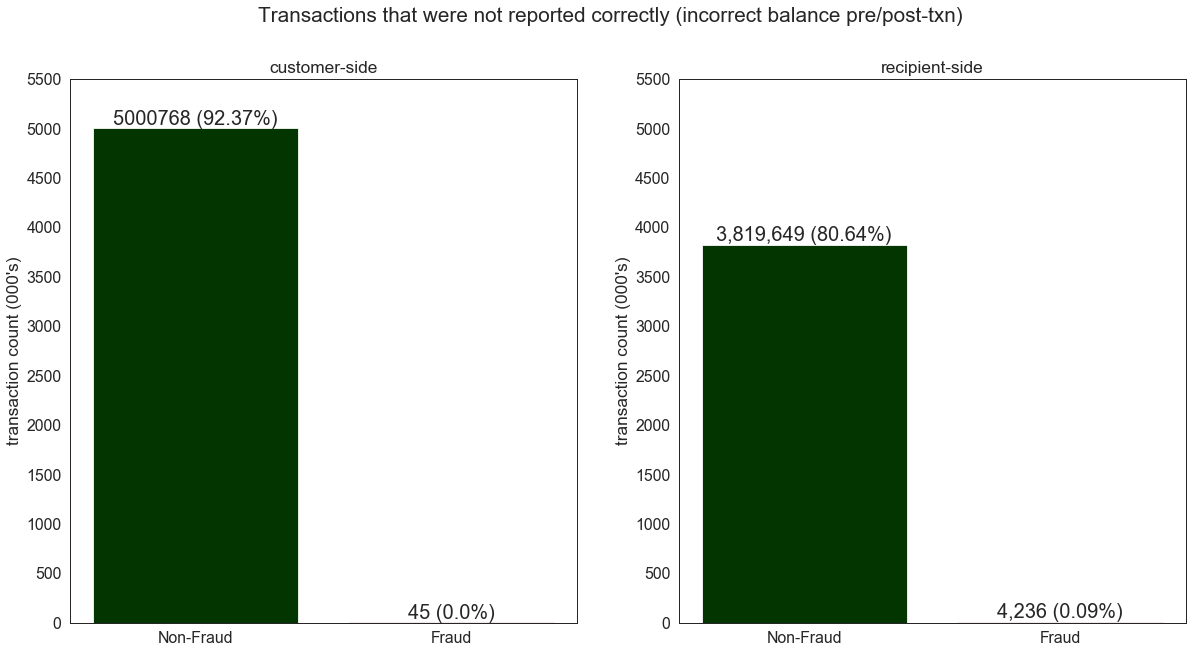

In [172]:
fig = plt.figure(figsize=(20, 10))

temp = df[df.customer_transaction==False].groupby(
    ["is_fraud"]).count().reset_index().sort_values("step", ascending=False)
ax = fig.add_subplot(1, 2, 1)
graph = plt.bar(temp.is_fraud, temp.step, color=["#033500", "#840000"])
plt.title("customer-side")
plt.ylabel("transaction count (000's)")
plt.yticks(range(0, 6000000, 500000), range(0, 6000, 500))
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             "{} ({}%)".format(
                 x, round(x / len(df[df.customer_check_balance != 0]) * 100, 2)),
             fontsize=20,
             ha="center",
             va="bottom")
    
    
temp = df[df.recipient_transaction==False].groupby(
    ["is_fraud"]).count().reset_index().sort_values("step", ascending=False)
ax = fig.add_subplot(1, 2, 2)
graph = plt.bar(temp.is_fraud, temp.step, color=["#033500", "#840000"])
plt.title("recipient-side")
plt.ylabel("transaction count (000's)")
plt.yticks(range(0, 6000000, 500000), range(0, 6000, 500))
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             "{:,} ({}%)".format(
                 x, round(x / len(df[df.recipient_check_balance != 0]) * 100, 2)),
             fontsize=20,
             ha="center",
             va="bottom")
    
plt.suptitle("Transactions that were not reported correctly (incorrect balance pre/post-txn)")   
plt.show()
del temp, ax, graph, bar, fig, x

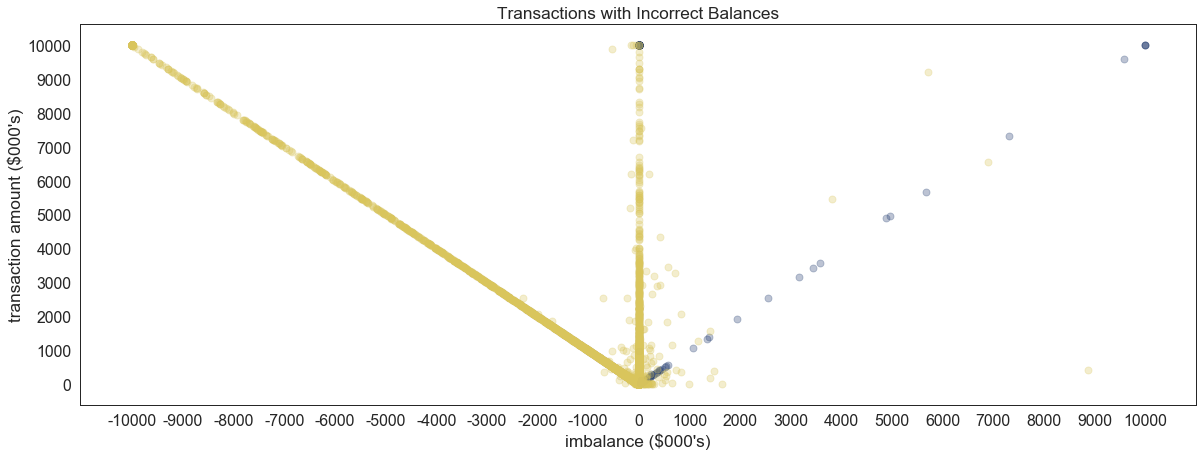

In [8]:
fig = plt.figure(figsize=(20, 7))
plt.scatter(df[(df.is_fraud == 1)
               & (df.customer_check_balance != 0)].customer_check_balance,
            df[(df.is_fraud == 1) & (df.customer_check_balance != 0)].amount,
            s=50,
            color="C0",
            alpha=0.3,
            label="customer")
plt.scatter(df[(df.is_fraud == 1)
               & (df.recipient_check_balance != 0)].recipient_check_balance,
            df[(df.is_fraud == 1) & (df.recipient_check_balance != 0)].amount,
            s=50,
            color="C5",
            alpha=0.3,
            label="recipient")
plt.xlabel("imbalance ($000's)")
plt.xticks(range(-10000000, 11000000, 1000000), range(-10000, 11000, 1000))
plt.ylabel("transaction amount ($000's)")
plt.yticks(range(0, 11000000, 1000000), range(0, 11000, 1000))
plt.title("Transactions with Incorrect Balances")
plt.show()
del fig

## is_flagged_fraud

There are only 16 transactions that were flagged in this dataset. If we were to follow the definition provided above, there should be 1673570 flagged transactions.

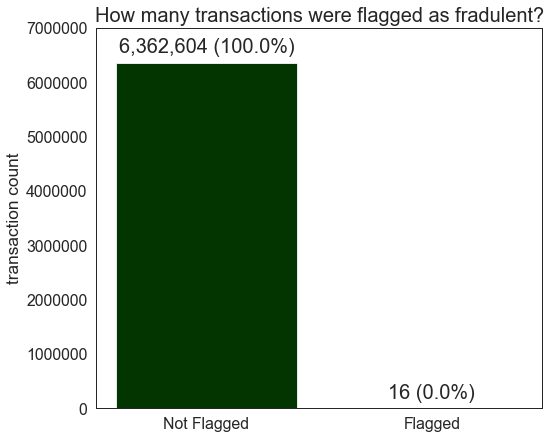

In [165]:
temp = df.groupby(["is_flagged_fraud"]).count().reset_index()
fig = plt.figure(figsize=(8, 7))
graph = plt.bar(temp.is_flagged_fraud, temp.step, color=["#033500", "#840000"])
plt.title("How many transactions were flagged as fradulent?", fontsize=20)
plt.ylabel("transaction count")
plt.yticks(range(0, 8000000, 1000000))
plt.xticks([0, 1], ["Not Flagged", "Flagged"])
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bar.get_height() + 100000,
             "{:,} ({}%)".format(x, round(x / len(df) * 100, 2)),
             fontsize=20,
             ha="center",
             va="bottom")
plt.show()
del temp, fig, graph

In [166]:
df[["amount", "is_flagged_fraud"
    ]].pivot(columns="is_flagged_fraud").describe()

amount              
is_flagged_fraud             0             1
count            6,362,604.00  16.00        
mean             179,850.13    4,861,597.73 
std              603,788.43    3,572,499.10 
min              0.00          353,874.22   
25%              13,389.55     2,242,748.72 
50%              74,871.27     4,234,245.09 
75%              208,720.47    7,883,451.38 
max              92,445,516.64 10,000,000.00

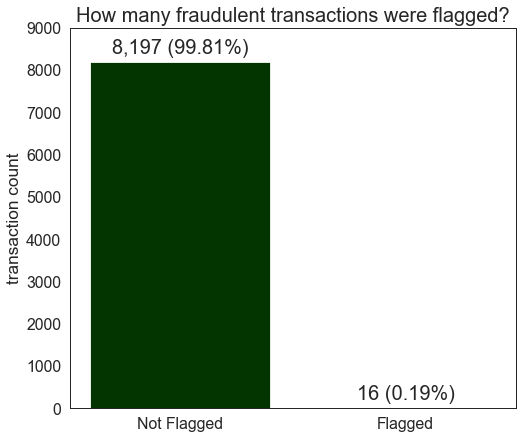

In [169]:
temp = df[df.is_fraud==1].groupby(["is_flagged_fraud"]).count().reset_index()
fig = plt.figure(figsize=(8, 7))
graph = plt.bar(temp.is_flagged_fraud, temp.step, color=["#033500", "#840000"])
plt.title("How many fraudulent transactions were flagged?", fontsize=20)
plt.ylabel("transaction count")
plt.yticks(range(0, 10000, 1000))
plt.xticks([0, 1], ["Not Flagged", "Flagged"])
for bar, x in zip(graph, temp.step.values):
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bar.get_height() + 100,
             "{:,} ({}%)".format(x, round(x / len(df[df.is_fraud==1]) * 100, 2)),
             fontsize=20,
             ha="center",
             va="bottom")
plt.show()
del temp, fig, graph

In [304]:
print("There are {} transations above $200K.".format(len(df[df.amount>200000])))

There are 1673570 transations above $200K.


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


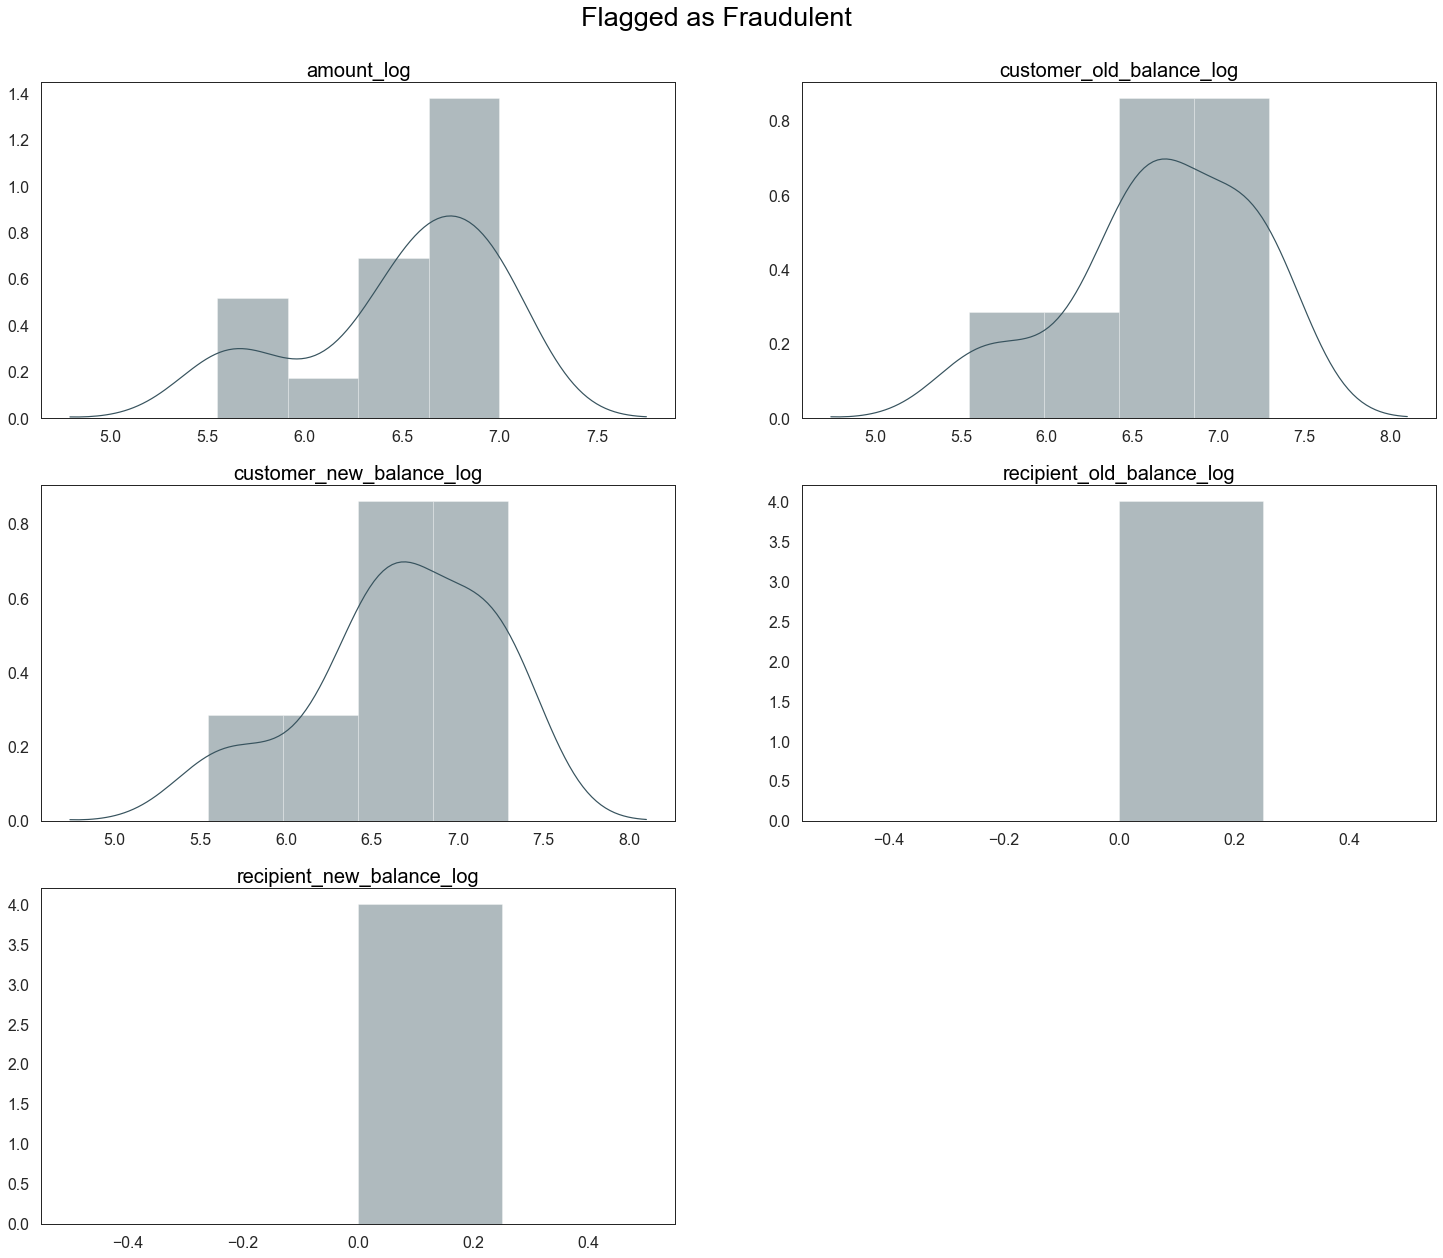

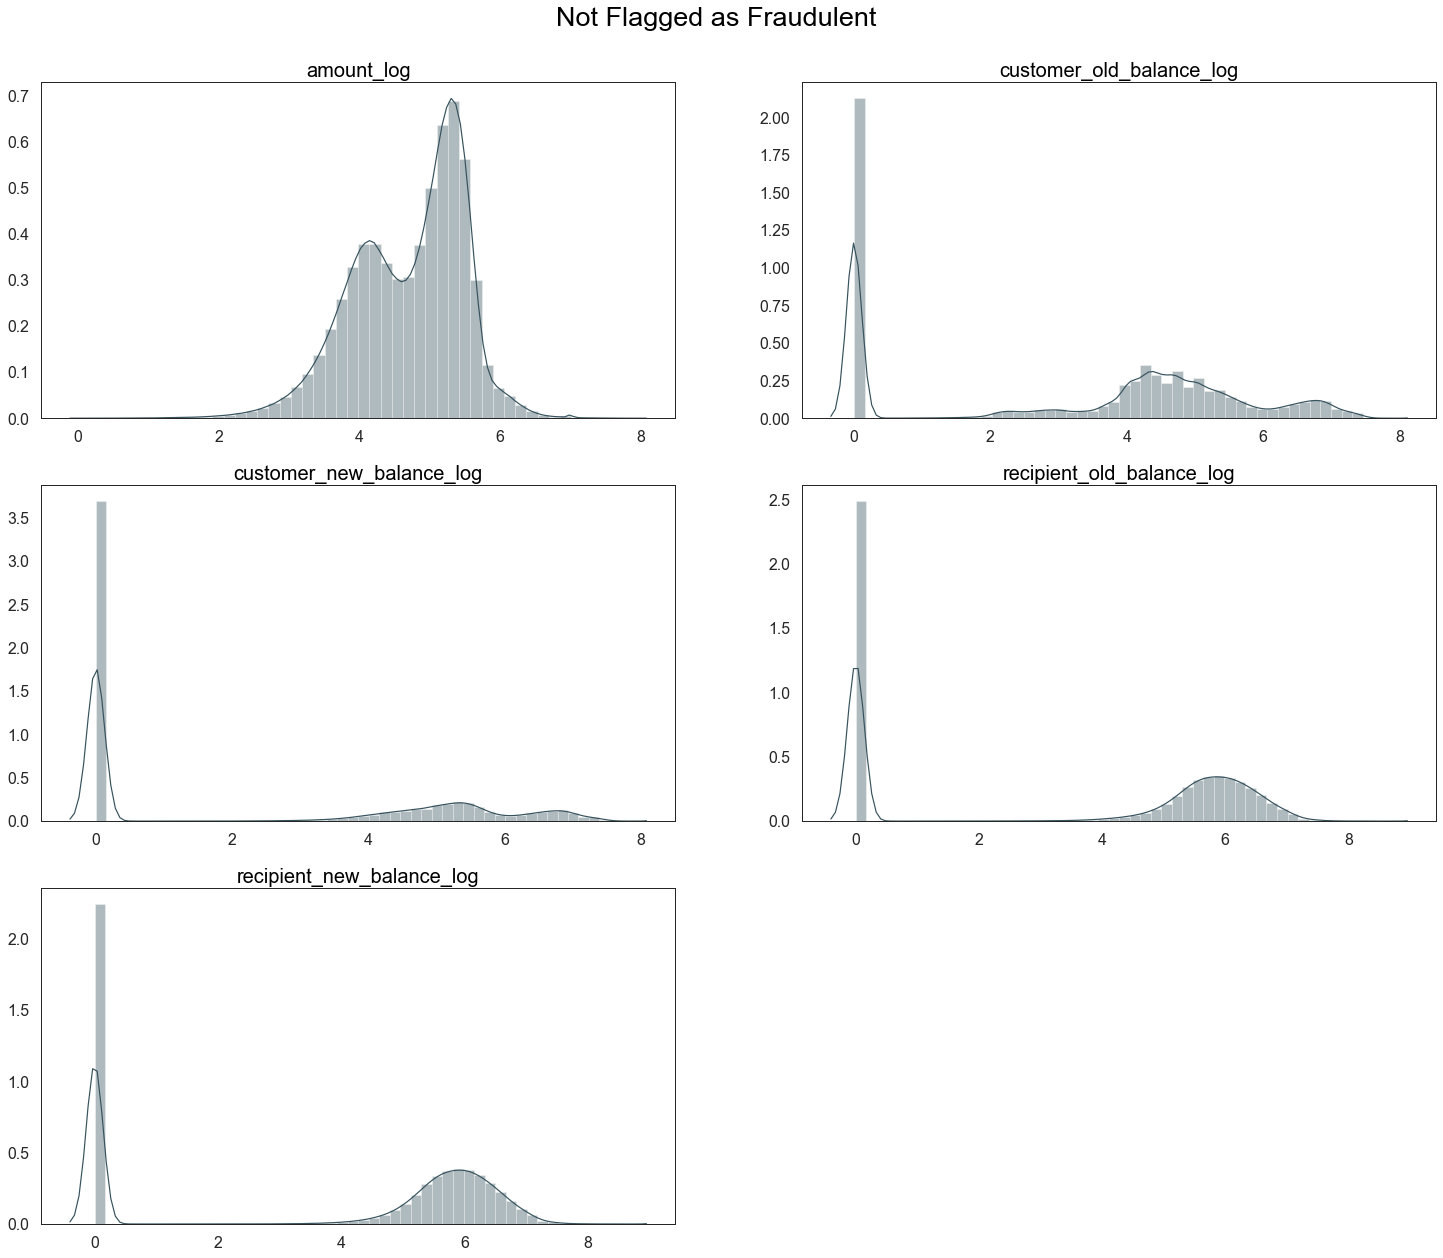

In [82]:
r = math.ceil(len(normalised)/2)

for key, val in dict(
        zip([1, 0],
            ["Flagged as Fraudulent", "Not Flagged as Fraudulent"])).items():
    fig = plt.figure(figsize=(25, 7*r))
    for i, col in enumerate(normalised):
        ax = fig.add_subplot(r, 2, i + 1)
        sns.distplot(df.query("is_flagged_fraud == @key")[col])
        plt.xlabel(None)
        plt.title(col, fontsize=20, color="black")
    plt.suptitle(val, fontsize=27, y=0.93, color="black")
    plt.show()

In [88]:
df = pickle.load(open("fraud_v1.pkl", "rb"))

In [89]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
step                      6362620 non-null int64
type                      6362620 non-null object
amount                    6362620 non-null float64
customer                  6362620 non-null object
customer_old_balance      6362620 non-null float64
customer_new_balance      6362620 non-null float64
recipient                 6362620 non-null object
recipient_old_balance     6362620 non-null float64
recipient_new_balance     6362620 non-null float64
is_fraud                  6362620 non-null int64
is_flagged_fraud          6362620 non-null int64
customer_with_history     35626 non-null float64
recipient_with_history    35626 non-null float64
dtypes: float64(7), int64(3), object(3)
memory usage: 631.1+ MB


In [100]:
df.fillna(0, inplace=True)
df.isnull().sum()

step                      0
type                      0
amount                    0
customer                  0
customer_old_balance      0
customer_new_balance      0
recipient                 0
recipient_old_balance     0
recipient_new_balance     0
is_fraud                  0
is_flagged_fraud          0
customer_with_history     0
recipient_with_history    0
dtype: int64

In [101]:
df["with_history"] = df["customer_with_history"] + df["recipient_with_history"]

In [ ]:
sns.

In [21]:
print("There are {} customers appeared more than once.".format(
    len(df[df.customer.duplicated(keep="first") == True].customer)))

There are 9313 customers appeared more than once.


In [22]:
print("There are {} recipients appeared more than once.".format(
    len(df[df.recipient.duplicated(keep="first") == True].recipient)))

There are 3640258 recipients appeared more than once.


In [23]:
print("There are {} IDs that are both customer and recipient.".format(
    len(
        pd.DataFrame(df.customer.unique()).merge(pd.DataFrame(
            df.recipient.unique()),
                                                 how="inner"))))

There are 1769 IDs that are both customer and recipient.


In [24]:
print("There are {} merchants that initiated transactions.".format(
    len(df[df.customer.str.contains("M")])))

There are 0 merchants that initiated transactions.


In [25]:
print("There are {} merchants as recipients.".format(
    len(df[df.recipient.str.contains("M")])))

There are 2151495 merchants as recipients.


In [26]:
cols = ["type", "is_fraud", "is_flagged_fraud"]
print("=====Merchant as Recipient=====")
for col in cols:
    print("FEATURE: ", col)
    print(df[df.recipient.str.contains("M")][col].value_counts(normalize=True)*100)

=====Merchant as Recipient=====
FEATURE:  type
PAYMENT    100.0
Name: type, dtype: float64
FEATURE:  is_fraud
0    100.0
Name: is_fraud, dtype: float64
FEATURE:  is_flagged_fraud
0    100.0
Name: is_flagged_fraud, dtype: float64


In [9]:
df["customer_check_balance"] = df["customer_new_balance"] - (df["customer_old_balance"] - df["amount"])

df["recipient_check_balance"] = df["recipient_new_balance"] - (df["recipient_old_balance"] + df["amount"])

In [12]:
pickle.dump(df, open("fraud.pkl", "wb"))

In [29]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
step                       6362620 non-null int64
type                       6362620 non-null object
amount                     6362620 non-null float64
customer                   6362620 non-null object
customer_old_balance       6362620 non-null float64
customer_new_balance       6362620 non-null float64
recipient                  6362620 non-null object
recipient_old_balance      6362620 non-null float64
recipient_new_balance      6362620 non-null float64
is_fraud                   6362620 non-null int64
is_flagged_fraud           6362620 non-null int64
customer_with_history      35626 non-null float64
recipient_with_history     35626 non-null float64
customer_check_balance     6362620 non-null float64
recipient_check_balance    6362620 non-null float64
dtypes: float64(9), int64(3), object(3)
memory usage: 728.1+ MB


In [429]:
df.fillna(0, inplace=True)
pickle.dump(df, open("fraud2.pkl", "wb"))

In [32]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
step                       6362620 non-null int64
type                       6362620 non-null object
amount                     6362620 non-null float64
customer                   6362620 non-null object
customer_old_balance       6362620 non-null float64
customer_new_balance       6362620 non-null float64
recipient                  6362620 non-null object
recipient_old_balance      6362620 non-null float64
recipient_new_balance      6362620 non-null float64
is_fraud                   6362620 non-null int64
is_flagged_fraud           6362620 non-null int64
customer_with_history      6362620 non-null float64
recipient_with_history     6362620 non-null float64
customer_check_balance     6362620 non-null float64
recipient_check_balance    6362620 non-null float64
dtypes: float64(9), int64(3), object(3)
memory usage: 728.1+ MB


In [14]:
del IDs_with_fraud

In [15]:
x = pickle.load(open("fraud.pkl", "rb"))
display(x.head())
del x

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_with_history,recipient_with_history,customer_check_balance,recipient_check_balance
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,NaN,NaN,0.0,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,NaN,NaN,0.0,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,NaN,NaN,0.0,-181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,NaN,NaN,0.0,-21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,NaN,NaN,0.0,-11668.14


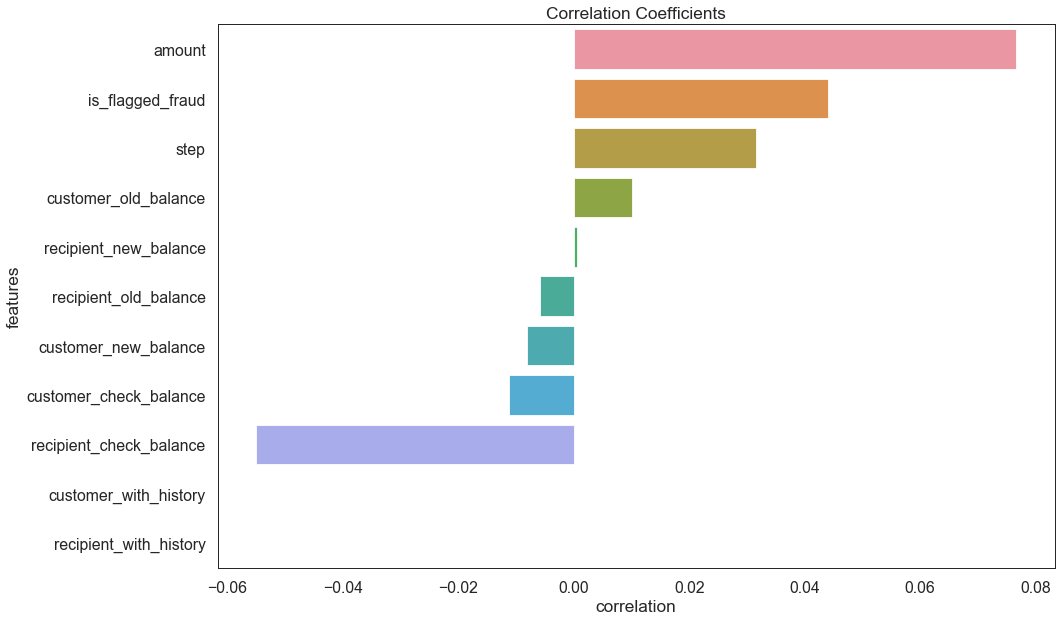

In [10]:
corr_table = df.corr()[["is_fraud"]].sort_values("is_fraud", ascending=False).iloc[1:,:].reset_index()
plt.figure(figsize=(15,10))
sns.barplot(x="is_fraud", y="index", data=corr_table)
plt.xlabel("correlation")
plt.ylabel("features")
plt.title("Correlation Coefficients")
plt.show()

In [82]:
df_fraud = df.query("is_fraud == 1")
df_not_fraud = df.query("is_fraud == 0")
df_flagged = df.query("is_flagged_fraud == 1")
df_not_flagged = df.query("is_flagged_fraud == 0")

In [83]:
print("There are {} customers with fraudulent transactions".format(
    df_fraud.customer.nunique()))

There are 8213 customers with fraudulent transactions


In [84]:
print("There are {} recipient under fraudulent transactions".format(
    df_fraud.recipient.nunique()))

There are 8169 recipient under fraudulent transactions


In [85]:
print(
    "There are {} customers who have made both fraudulent and non-fraudulent transactions."
    .format(
        len(df_fraud[["customer"]].merge(df_not_fraud[["customer"]],
                                         how="inner"))))

There are 28 customers who have made both fraudulent and non-fraudulent transactions.


In [87]:
print(
    "There are {} IDs who have been recipient of both fraudulent and non-fraudulent transactions."
    .format(
        len(df_fraud[["recipient"]].merge(df_not_fraud[["recipient"]],
                                         how="inner"))))

There are 58186 IDs who have been recipient of both fraudulent and non-fraudulent transactions.


In [88]:
print(
    "There are {} customers who have both flagged and not flagged transactions ."
    .format(
        len(df_flagged[["customer"]].merge(df_not_flagged[["customer"]],
                                           how="inner"))))

There are 0 customers who have both flagged and not flagged transactions .


In [90]:
print(
    "There are {} recipients who have both flagged and not flagged transactions ."
    .format(
        len(df_flagged[["recipient"]].merge(df_not_flagged[["recipient"]],
                                           how="inner"))))

There are 8 recipients who have both flagged and not flagged transactions .


In [91]:
print(
    "There are {} IDs who have fraudulent transactions as both customer and recipient."
    .format(
        len(df_fraud[["customer"]].merge(df_fraud[["recipient"]],
                                         how="inner",
                                         left_on="customer",
                                         right_on="recipient"))))

There are 0 IDs who have fraudulent transactions as both customer and recipient.


In [92]:
print(
    "There are {} IDs who have fraudulent transactions as customer but none as recipient."
    .format(
        len(df_fraud[["customer"]].merge(df_not_fraud[["recipient"]],
                                         how="inner",
                                         left_on="customer",
                                         right_on="recipient"))))

There are 0 IDs who have fraudulent transactions as customer but none as recipient.


In [93]:
df.query("is_flagged_fraud==0 & (customer_with_history==1 | recipient_with_history==1) & is_fraud==1")

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_with_prior,recipient_with_prior
4858,5,CASH_OUT,120074.73,C1174000532,120074.73,0.0,C410033330,0.00,120074.73,1,0,0,1
1030736,88,CASH_OUT,4022408.76,C987446721,4022408.76,0.0,C1981613973,4542879.50,8565288.26,1,0,0,1
1048324,95,CASH_OUT,87999.25,C409531429,87999.25,0.0,C1827219533,0.00,87999.25,1,0,0,1
1059579,105,CASH_OUT,511379.90,C1440012977,511379.90,0.0,C644163395,3439249.70,3950629.60,1,0,0,1
3208638,249,CASH_OUT,369448.20,C2020495090,369448.20,0.0,C650699445,0.00,369448.20,1,0,0,1
6008662,436,CASH_OUT,4135944.29,C1649836304,4135944.29,0.0,C14138104,0.00,4135944.29,1,0,0,1
6168708,560,CASH_OUT,143275.81,C1571623448,143275.81,0.0,C1655359478,6346481.09,6489756.90,1,0,0,1
6255874,597,CASH_OUT,517183.38,C1850286862,517183.38,0.0,C1837027614,0.00,517183.38,1,0,0,1
6272188,621,CASH_OUT,425861.93,C2103073329,425861.93,0.0,C686334805,203280.85,629142.78,1,0,0,1
6281786,650,CASH_OUT,50523.78,C1711085884,50523.78,0.0,C1148781766,0.00,50523.78,1,0,0,1
